In [ ]:
!pip install datasets transformers sentence_transformers openai cohere

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from datasets import load_dataset


In [ ]:
# https://huggingface.co/datasets/urvog/llama2_transcripts_healthcare_callcenter
callcenter_dataset = load_dataset("urvog/llama2_transcripts_healthcare_callcenter")

In [ ]:
callcenter_dataset['train'][0]

{'text': "<s>[INST] Classify the following call transcript:\n\nAgent 3: Thank you for calling HealthHarbor, my name is Agent 3. How can I assist you today?\n\nCustomer: Hi Agent 3, my name is Emma Johnson. I've been experiencing some symptoms lately and I wanted to seek medical advice or get a symptom assessment.\n\nAgent 3: I'm sorry to hear that, Emma. I'll do my best to help you. Can you please describe the symptoms you've been experiencing?\n\nCustomer: Sure. I've been having a persistent headache for the past few days, and it's been accompanied by dizziness and occasional nausea. I'm not sure what could be causing it.\n\nAgent 3: I understand your concern, Emma. Headaches can have various causes. Have you experienced any recent changes in your lifestyle or any other symptoms besides the headache, dizziness, and nausea?\n\nCustomer: No major lifestyle changes, but I have noticed that my vision seems a bit blurry at times. And I've been feeling more fatigued than usual.\n\nAgent 3: 

# Let's turn our data into a Pandas DataFrame

In [ ]:
import pandas as pd

text_df = pd.DataFrame(callcenter_dataset['train'])

def parse_transcript(convo):
    turns = convo.split('\n\n')[1:]
    turns = [[t.split(': ')[0], ': '.join(t.split(': ')[1:])] for t in turns]
    turns[-1][-1] = turns[-1][-1].split('[/INST]')[0].strip()
    return turns

text_df['convo'] = text_df['text'].apply(parse_transcript)

text_df['label'] = text_df['text'].apply(lambda x: x.split('[/INST]')[-1].split('</s>')[0].strip())

text_df.head()

,text,convo,label
0,<s>[INST] Classify the following call transcri...,"[[Agent 3, Thank you for calling HealthHarbor,...",Medical Advice or Symptom Assessment
1,<s>[INST] Classify the following call transcri...,"[[Agent 2, Thank you for calling HealthHarbor,...",General Inquiries
2,<s>[INST] Classify the following call transcri...,"[[Agent 4, Thank you for calling HealthHarbor,...",Lab and Test Results
3,<s>[INST] Classify the following call transcri...,"[[Agent 1, Thank you for calling HealthHarbor,...",Follow-up Calls and Care Management
4,<s>[INST] Classify the following call transcri...,"[[[Phone ringing], ], [Agent 3, Thank you for ...",Medication Refills and Prescription Inquiries


In [ ]:
dataset = load_dataset("gretelai/symptom_to_diagnosis")
text_df = pd.DataFrame(list(dataset['train']) + list(dataset['test']))
text_df['text'] = text_df['input_text']
text_df['label'] = text_df['output_text']

In [ ]:
text_df.head()

,output_text,input_text,text,label
0,cervical spondylosis,I've been having a lot of pain in my neck and ...,I've been having a lot of pain in my neck and ...,cervical spondylosis
1,impetigo,I have a rash on my face that is getting worse...,I have a rash on my face that is getting worse...,impetigo
2,urinary tract infection,I have been urinating blood. I sometimes feel ...,I have been urinating blood. I sometimes feel ...,urinary tract infection
3,arthritis,I have been having trouble with my muscles and...,I have been having trouble with my muscles and...,arthritis
4,dengue,I have been feeling really sick. My body hurts...,I have been feeling really sick. My body hurts...,dengue


<Axes: title={'center': 'Distribution of actual conversation labels'}, xlabel='label'>

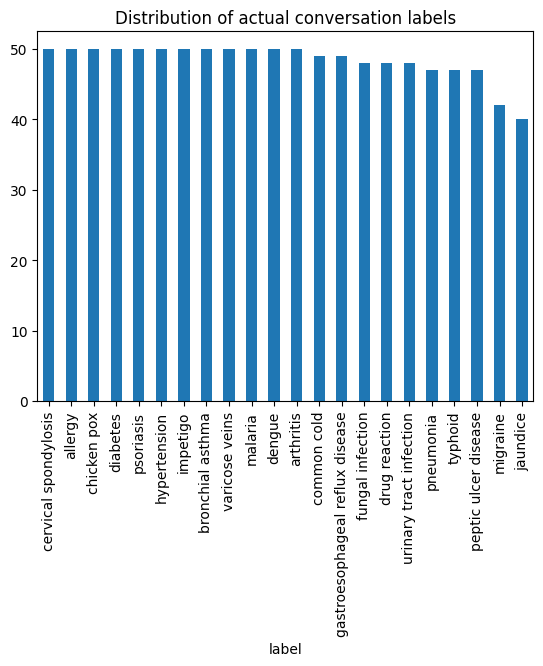

In [ ]:
text_df['label'].value_counts().plot.bar(
    title='Distribution of actual conversation labels'
)

# Model 1: embed text

Using https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [ ]:
import sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embeddings = {
    'all-mpnet-base-v2': SentenceTransformer('sentence-transformers/all-mpnet-base-v2').encode(text_df['text'], show_progress_bar=True),
    'all-MiniLM-L6-v2': SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').encode(text_df['text'], show_progress_bar=True),
    'xlm-r-distilroberta-base-paraphrase-v1': SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1').encode(text_df['text'], show_progress_bar=True),
}

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
# Variables to store results
def eval_cluster(embeddings, range_n_clusters = range(5, 31)):
    sse = []  # Sum of squared distances
    silhouette_avg = []  # Silhouette score average

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(embeddings)
        sse.append(kmeans.inertia_)

        # Calculate silhouette score
        labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(embeddings, labels))

    return sse, silhouette_avg, labels

In [ ]:
os_sse, os_silhouette_avg, os_labels = eval_cluster(embeddings['all-mpnet-base-v2'])

cluster_evals = {
    'all-mpnet-base-v2': {
        'sse': os_sse,
        'silhouette_avg': os_silhouette_avg,
        'labels': os_labels
    }
}

In [ ]:
os_2_sse, os_2_silhouette_avg, os_2_labels = eval_cluster(embeddings['all-MiniLM-L6-v2'])
cluster_evals['all-MiniLM-L6-v2'] = {
    'sse': os_2_sse,
    'silhouette_avg': os_2_silhouette_avg,
    'labels': os_2_labels
}

os_3_sse, os_3_silhouette_avg, os_3_labels = eval_cluster(embeddings['xlm-r-distilroberta-base-paraphrase-v1'])
cluster_evals['xlm-r-distilroberta-base-paraphrase-v1'] = {
    'sse': os_3_sse,
    'silhouette_avg': os_3_silhouette_avg,
    'labels': os_3_labels
}


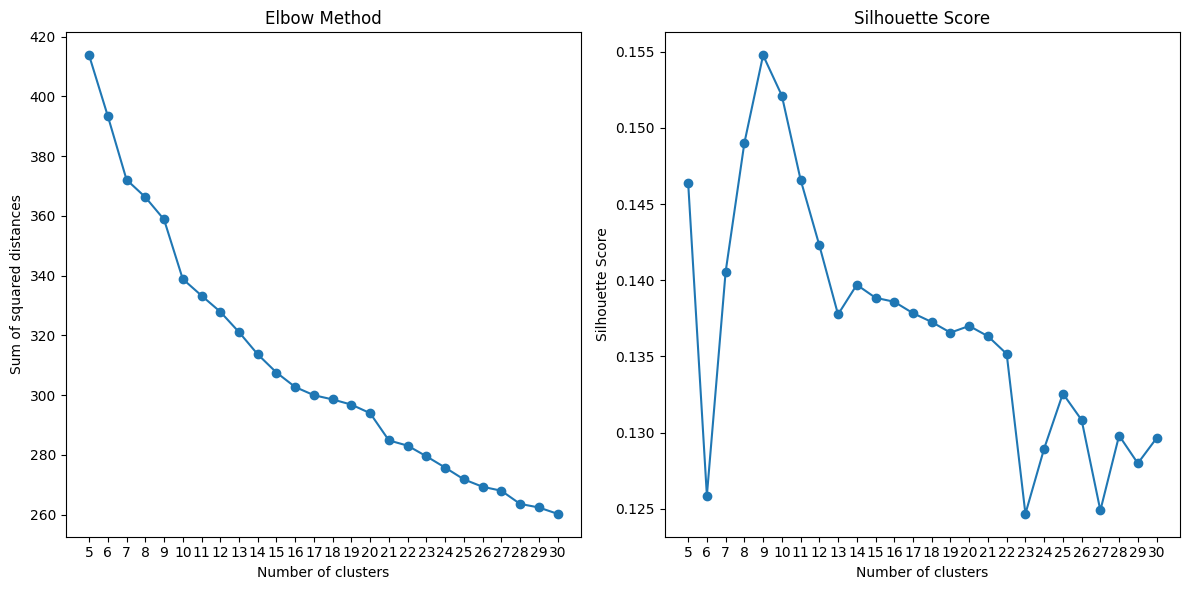

In [ ]:
# Plotting the Elbow Method graph
range_n_clusters = range(5, 31)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, os_sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

# Plotting the Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, os_silhouette_avg, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

plt.tight_layout()
plt.show()

# Try again with OpenAI

In [ ]:
from google.colab import userdata
from openai import OpenAI


client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

len(get_embeddings(['hi', 'hello'] , 'text-embedding-3-small'))

2

In [ ]:
ENGINES = ['text-embedding-3-large', 'text-embedding-ada-002', 'text-embedding-3-small']

for engine in ENGINES:
    embeddings['openai__'+engine] = get_embeddings(text_df['text'], engine)

In [ ]:
import cohere  # https://docs.cohere.com/reference/embed
co = cohere.Client(userdata.get('COHERE_API_KEY'))

COHERE_EMBEDDERS = ['embed-english-v3.0', 'embed-multilingual-v3.0', 'embed-english-v2.0']
for cohere_engine in COHERE_EMBEDDERS:
    embeddings[f'cohere__{cohere_engine}'] = co.embed(
        texts=list(text_df['text']),
        model=cohere_engine, input_type="clustering"
    ).embeddings

In [ ]:
len(embeddings)

9

In [ ]:
for embedding_engine, _embeddings in tqdm(embeddings.items()):
    sse, silhouette_avg, labels = eval_cluster(_embeddings)
    cluster_evals[embedding_engine] = {
        'sse': sse,
        'silhouette_avg': silhouette_avg,
        'labels': labels
    }

100%|██████████| 9/9 [01:42<00:00, 11.34s/it]


In [ ]:
for embedding_name, embedding_data in cluster_evals.items():
    print(f"Embedding: {embedding_name}")
    print(f"SSE: {min(embedding_data['sse'])}")
    print(f"Silhouette Score: {max(embedding_data['silhouette_avg'])}")
    print()

Embedding: all-mpnet-base-v2
SSE: 260.2655334472656
Silhouette Score: 0.1547660529613495

Embedding: all-MiniLM-L6-v2
SSE: 320.1070251464844
Silhouette Score: 0.15413159132003784

Embedding: xlm-r-distilroberta-base-paraphrase-v1
SSE: 11498.6318359375
Silhouette Score: 0.11930572241544724

Embedding: openai__text-embedding-3-large
SSE: 328.5574079988636
Silhouette Score: 0.142255802430213

Embedding: openai__text-embedding-ada-002
SSE: 91.43504839270918
Silhouette Score: 0.12496659798382632

Embedding: openai__text-embedding-3-small
SSE: 313.62636593413805
Silhouette Score: 0.12065360887377127

Embedding: cohere__embed-english-v3.0
SSE: 252.44925705236216
Silhouette Score: 0.1228651350643473

Embedding: cohere__embed-multilingual-v3.0
SSE: 199.93730921670527
Silhouette Score: 0.12680047251404997

Embedding: cohere__embed-english-v2.0
SSE: 1706024.3947202545
Silhouette Score: 0.15137417182846247



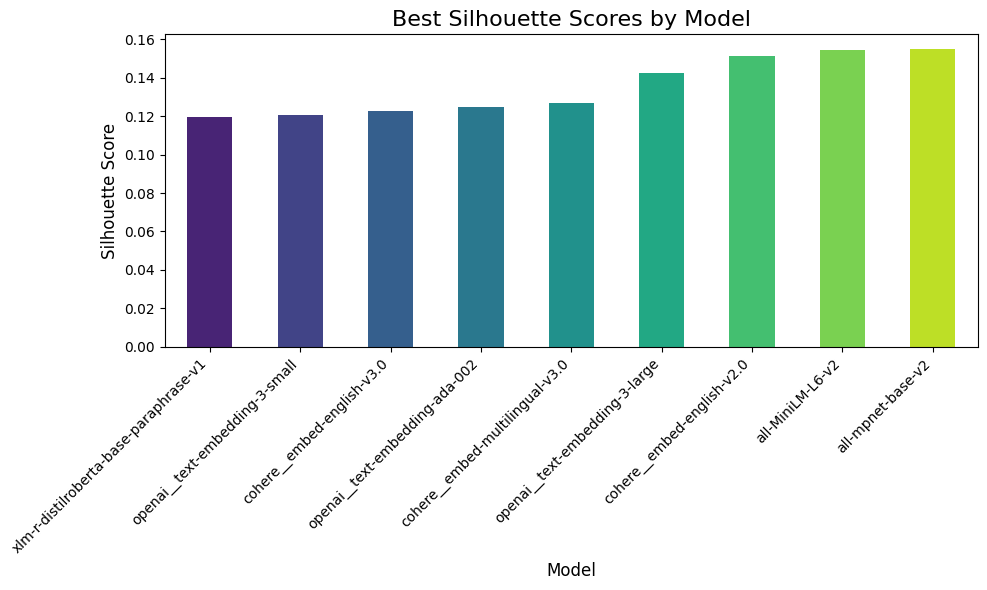

In [ ]:
cluster_eval_df = pd.DataFrame(cluster_evals).T
import seaborn as sns
import matplotlib.pyplot as plt
df = cluster_eval_df.applymap(lambda x: max(x))['silhouette_avg'].sort_values(
    ascending=True)
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='bar', color=sns.color_palette("viridis", len(df)), ax=ax)
ax.set_title('Best Silhouette Scores by Model', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)

# Rotate x-axis labels to prevent overlapping
ax.set_xticklabels(df.index, rotation=45, ha="right")

# Optional: Set a buffer around the x-axis labels to ensure they fit in the figure
plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()


In [ ]:
cluster_eval_df

,sse,silhouette_avg,labels
all-mpnet-base-v2,"[413.7497863769531, 393.39801025390625, 372.08...","[0.14640607, 0.12586077, 0.14054222, 0.1489988...","[4, 11, 12, 27, 6, 1, 18, 23, 11, 26, 27, 4, 4..."
all-MiniLM-L6-v2,"[512.4398193359375, 475.2136535644531, 445.671...","[0.12720889, 0.14510484, 0.14560066, 0.1541315...","[9, 8, 7, 6, 20, 28, 22, 20, 8, 16, 6, 9, 9, 7..."
xlm-r-distilroberta-base-paraphrase-v1,"[17323.5625, 16542.546875, 15970.10546875, 156...","[0.113634266, 0.11278692, 0.11930572, 0.115039...","[2, 16, 13, 21, 17, 25, 5, 17, 22, 15, 19, 2, ..."
openai__text-embedding-3-large,"[491.4028631053612, 468.25399932886734, 451.76...","[0.10598471986887614, 0.11400645289438928, 0.1...","[3, 28, 17, 15, 18, 10, 18, 2, 28, 19, 15, 3, ..."
openai__text-embedding-ada-002,"[134.68102180124708, 129.1322259296785, 124.41...","[0.10462777115086912, 0.09789645562621387, 0.1...","[2, 29, 17, 27, 13, 1, 18, 13, 29, 16, 27, 2, ..."
openai__text-embedding-3-small,"[456.33472045957313, 437.83112262650866, 422.9...","[0.10947612848572366, 0.11254328022789707, 0.1...","[8, 20, 22, 6, 18, 18, 27, 18, 20, 2, 6, 8, 8,..."
cohere__embed-english-v3.0,"[375.7783678684019, 353.2732168184056, 346.326...","[0.0882694047843916, 0.11135379272435102, 0.10...","[8, 25, 24, 19, 12, 10, 16, 4, 25, 2, 19, 8, 8..."
cohere__embed-multilingual-v3.0,"[288.62903735187007, 279.28491018537176, 268.8...","[0.09974678637434589, 0.1090262688238912, 0.11...","[22, 28, 21, 15, 19, 17, 19, 18, 28, 12, 15, 3..."
cohere__embed-english-v2.0,"[2774738.890764295, 2642493.3469692958, 251606...","[0.10941738677862145, 0.12171272628463235, 0.1...","[15, 18, 6, 23, 1, 17, 12, 8, 18, 25, 23, 15, ..."


In [ ]:
best_embedder = cluster_eval_df.applymap(lambda x: max(x))['silhouette_avg'].sort_values(
    ascending=True).index[-1]

print(f"Best Embedder: {best_embedder}")

Best Embedder: all-mpnet-base-v2


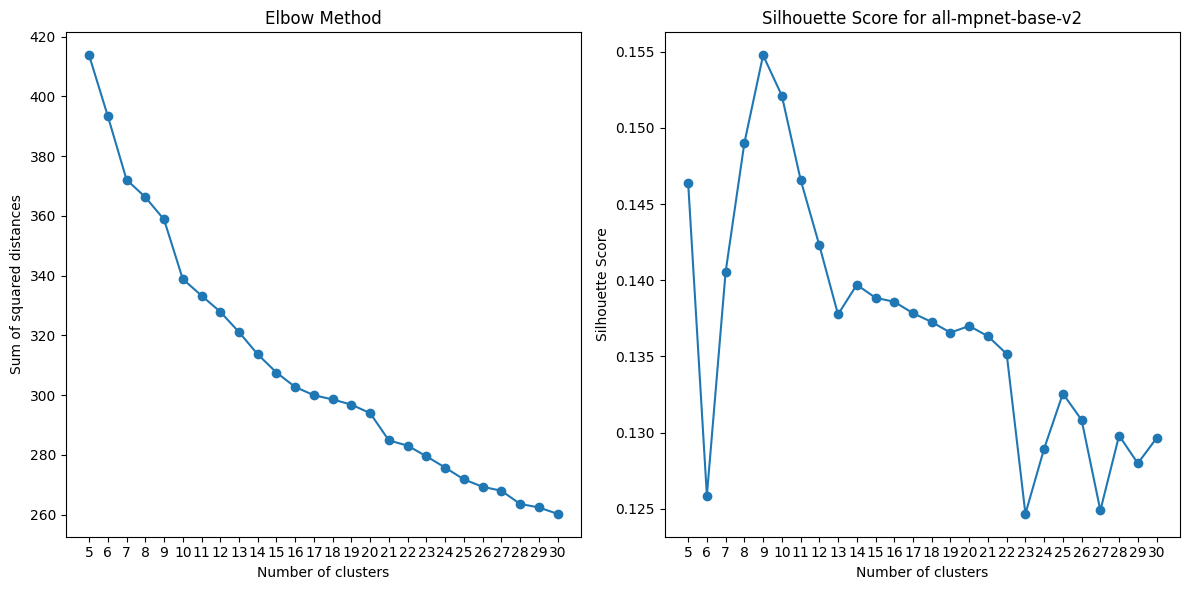

In [ ]:
# Plotting the Elbow Method graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, cluster_eval_df.loc[best_embedder]['sse'], marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

# Plotting the Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, cluster_eval_df.loc[best_embedder]['silhouette_avg'], marker='o')
plt.title(f'Silhouette Score for {best_embedder}')
plt.xlabel('Number of clusters')
plt.ylabel(f'Silhouette Score')
plt.xticks(range_n_clusters)  # Set x-axis ticks to integer values

plt.tight_layout()
plt.show()